**Problema Sesión 04** 
(AUMENTA EL N.º DE IMÁGENES Y EXPLORA LA RED CONVOLUCIONAL)


**Realizado por:** Hugo Cordoba

### Cargar las librerías

Primero cargamos las librerías que vamos a necesitar

In [256]:
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.metrics import confusion_matrix

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim

Tamaño de la imágen:  (128, 128)


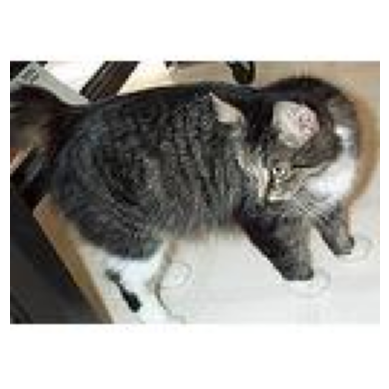

In [257]:
# Ver un ejemplo de una de las imágenes
# Leer la imagen con Pillow (PIL)
image = Image.open(os.path.join('./cat_0425.jpg'))
print("Tamaño de la imágen: ", image.size)
plt.imshow(image)
plt.axis('off')
plt.show()

**2. Transformacion de la imagen**

In [258]:
# Mostrar la imagen original junto con la imagen transformada
def plot_images(image, image_trans, title, title_trans):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,10))
    ax[0].imshow(image)
    ax[0].set_title(title)
    ax[1].imshow(image_trans)
    ax[1].set_title(title_trans)
    plt.show()

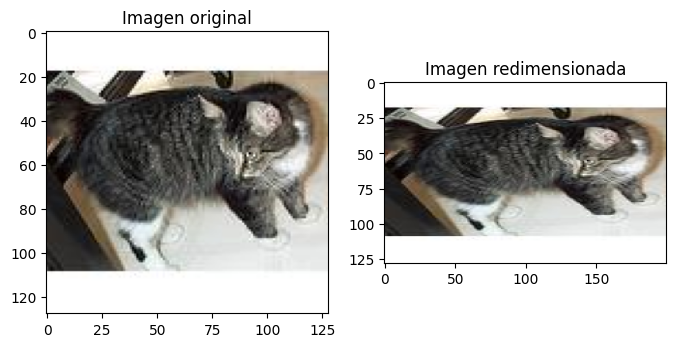

In [259]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imágen es en formato PIL
    v2.Resize(size=(128, 200), antialias=True), # Cambiar el tamaño a 128 x 200
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

resize_image = transforms(image)

plot_images(image, resize_image, 'Imagen original', 'Imagen redimensionada')

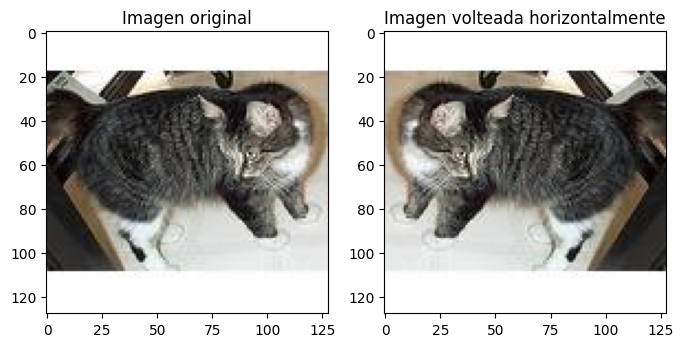

In [260]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
    v2.RandomHorizontalFlip(p=1), # p=1 probabilidad de voltear es 1. Se puede cambiar a 0.5 para voltear solamente la mitad de las imágenes
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen volteada horizontalmente')

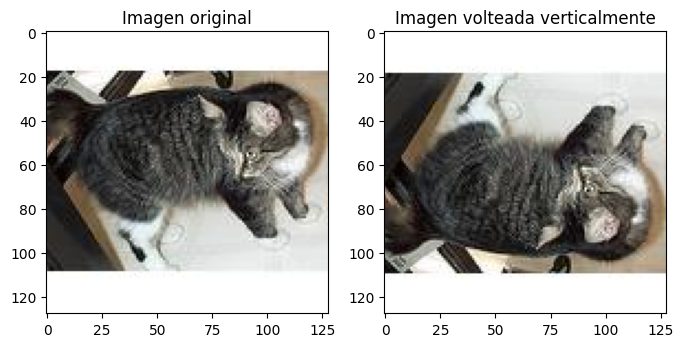

In [261]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
    v2.RandomVerticalFlip(p=1), # p=1 probabilidad de voltear es 1. Se puede cambiar a 0.5 para voltear solamente la mitad de las imágenes
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen volteada verticalmente')

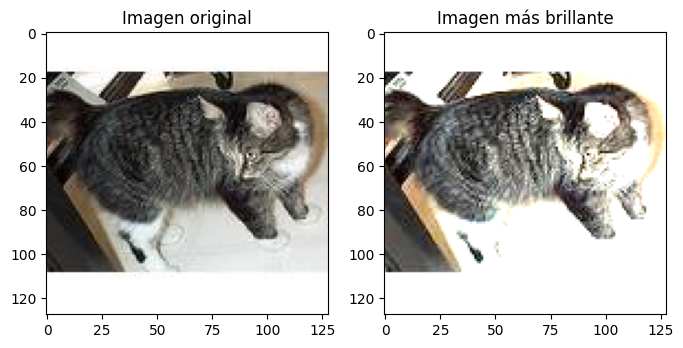

In [262]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
    v2.ColorJitter(brightness=3), # parametro brightness determina qué tan brillante es la imagen 
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen más brillante')

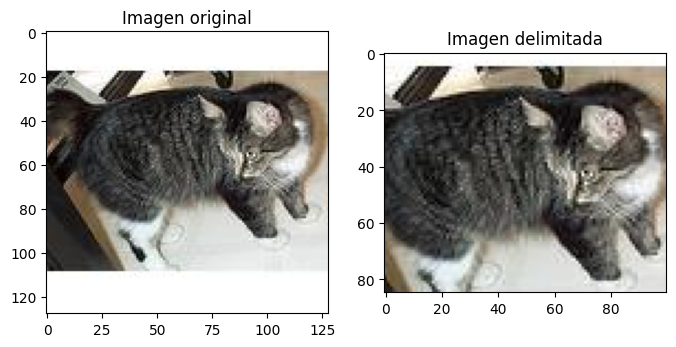

In [263]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
    v2.RandomCrop(size=(85,100)), # size especifica el tamaño nuevo de la imagen 
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen delimitada')

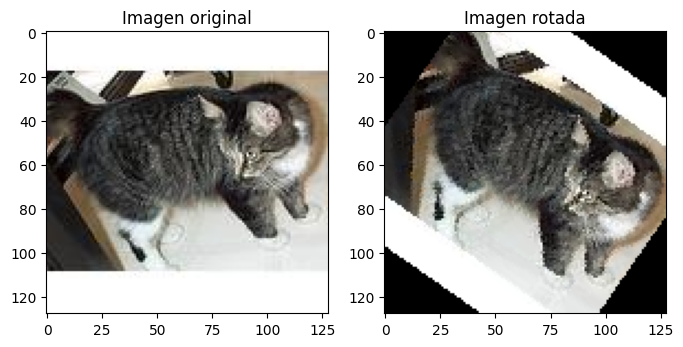

In [264]:
transforms = v2.Compose([
    v2.ToImage(),  # Convertir la imagen a un tensor ya que nuestra imagen es en formato PIL
    v2.RandomRotation(degrees=95), # degrees especifica cuánto rotar la imagen 
    v2.ToPILImage(), # Convertirla de nueva a PIL para poder mostrarla
])

transformed_image = transforms(image)
plot_images(image, transformed_image, 'Imagen original', 'Imagen rotada')

**3. Cargar el conjunto de datos de CIFAR10**

In [265]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Definir transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir la imagen a un tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los valores de los píxeles a un rango [-1, 1]
])

# Cargar conjunto de datos CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Verificar la longitud de los conjuntos de datos
print("Número de imágenes en el conjunto de entrenamiento:", len(train_dataset))
print("Número de imágenes en el conjunto de prueba:", len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
Número de imágenes en el conjunto de entrenamiento: 50000
Número de imágenes en el conjunto de prueba: 10000


**4. Creacion del dataloader**

In [266]:
# Definir el tamaño del lote (batch size)
batch_size = 64

# Crear DataLoader para el conjunto de datos de entrenamiento
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Crear DataLoader para el conjunto de datos de prueba
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificar el tamaño de los DataLoaders
print("Número de lotes en el DataLoader de entrenamiento:", len(train_loader))
print("Número de lotes en el DataLoader de prueba:", len(test_loader))


Número de lotes en el DataLoader de entrenamiento: 782
Número de lotes en el DataLoader de prueba: 157


**5. Comprocion de varias versiones de 'cnn_model'**

In [267]:
# Definir las variaciones de capas convolucionales y de pooling
variations = [
    # (padding, stride, kernel_size, pooling_kernel_size, pooling_stride)
    (0, 1, 3, None, None),    # Capa convolucional con padding = 0 y stride = 1, kernel_size = 3, sin pooling
    (1, 1, 3, None, None),    # Capa convolucional con padding = 1 y stride = 1, kernel_size = 3, sin pooling
    (0, 1, 3, None, None),    # Capa convolucional con padding = 0 y stride = 1, kernel_size = 3, sin pooling
    (0, 2, 3, None, None),    # Capa convolucional con padding = 0 y stride = 2, kernel_size = 3, sin pooling
    (0, 1, 3, 2, 2),          # Capa convolucional con padding = 0 y stride = 1, kernel_size = 3, con pooling 2x2
    (0, 1, 3, 4, 4)           # Capa convolucional con padding = 0 y stride = 1, kernel_size = 3, con pooling 4x4
]

for i, (padding, stride, kernel_size, pooling_kernel_size, pooling_stride) in enumerate(variations):
    layers = [
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.ReLU(inplace=True)  # Función de activación ReLU
    ]
    if pooling_kernel_size is not None:
        layers.append(nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride))
    model = nn.Sequential(*layers)

    # Verificar el tamaño de entrada y salida
    for images, labels in train_loader:
        print(f'Variación {i+1}:')
        print('Input shape: ', images.shape)
        out = model(images)
        print('Output shape: ', out.shape)
        break



Variación 1:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 30, 30])
Variación 2:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 32, 32])
Variación 3:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 30, 30])
Variación 4:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 15, 15])
Variación 5:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 15, 15])
Variación 6:
Input shape:  torch.Size([64, 3, 32, 32])
Output shape:  torch.Size([64, 12, 7, 7])


## CUESTIONARIO FINAL

**¿Qué significa cada dimensión en la salida? (definición, número de filtros, número de ejemplos de datos, etc.)**

- Las diferentes dimensiones de la salida representan, el tamaño número de ejemplos de datos. Esta dimensión indica la cantidad de ejemplos de datos de entrada que se han procesado en un solo paso hacia adelante a través de la red neuronal. El número de filtros (o canales de salida). Esta dimensión corresponde al número de filtros que se han aplicado en la capa convolucional. Cada filtro detecta una característica específica en la imagen. Y por último, la altura y ancho de la salida. Estas dimensionesdeterminan la resolución espacial de la información extraída de la imagen de entrada.

**¿Cómo afecta una capa de pooling al tamaño de la salida?**

- Una capa de pooling reduce el tamaño de la salida al reducir el tamaño de la resolución espacial de los mapas de características. Esto se logra mediante la agrupación de regiones contiguas de la salida de la capa convolucional y calculando una estadística resumida, como el máximo valor (max pooling) o el promedio (average pooling), para cada región. Al reducir la resolución espacial, se disminuye la cantidad de parámetros en la red, lo que ayuda a controlar el sobreajuste y a mejorar la eficiencia computacional.

**¿Cómo afectan los parámetros de padding y stride al tamaño de la salida?**

- El padding consiste en agregar píxeles de borde alrededor de la imagen de entrada antes de aplicar la convolución. Esto puede ayudar a preservar el tamaño de la salida. Mientras que stride indica el paso con el que el filtro se desliza sobre la imagen de entrada durante la convolución. Un stride mayor resulta en una salida con una resolución espacial reducida.

**¿Cómo afecta el tamaño del filtro/núcleo al tamaño de la salida?**

-  El tamaño del filtro determina el campo receptivo de la capa convoluciona. Será entonces, el tamaño del área en la imagen de entrada que se toma en cuenta para calcular cada valor en la salida. Cuanto mayor es el filtro mayor es la captura características más globales de la imagen. Esto puede ocasiona una salida con una resolución espacial reducida. Mientras que, un filtro más pequeño captura características locales y puede preservar mejor la resolución espacial de la salida.

